In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Simulating a basic wavetank
The wave equation is one of the fundamentals of physics, arising from many different physical systems with a pleasing universality.  In electromagnetism waves propagating in free space obey the Helmholtz equation:
$$\left(\nabla^2 + {1\over c^{2}}\partial_t^2\right)\psi = 0$$
In lectures we'll work through this analytically, but it's actually fairly simple, and quite fun, to solve it numerically.  The code below is neither optimally fast nor incredibly accurate, but it should exhibit enough of the important physical phenomena that it's both fun and informative to play with.

In order to perform a very simple simulation, we must discretise the problem in both time and space.  If we start by discretising time, we can write each time step as $\psi_i$.  That leads to a very simple approximation of:
$$\left(\partial_t\psi\right)_{i-{1\over2}} \approx {\psi_i-\psi_{i-1} \over \Delta_t}$$
Similarly,

\begin{eqnarray}
\left(\partial_t^2\psi\right)_{i} & \approx & 
{\left(\partial_t\psi\right)_{i+{1\over2}}-
\left(\partial_t\psi\right)_{i-{1\over2}} 
\over \Delta_t}
\end{eqnarray}
\begin{eqnarray}
 & = & { \psi_{i+1} + \psi_{i-1} - 2\psi_i \over 2 \Delta_t}
\end{eqnarray}

This can be rearranged to give $\psi_{i+1}$ as a function of the previous time steps and the derivative:
$$\psi_{i+1} = 2\psi_i - \psi_{i+1} + 2\Delta_t\left(\partial_t^2\psi\right)_{i}$$
We can then substitute in from the Helmholtz equation to get:
$$\psi_{i+1} = 2\psi_i - \psi_{i+1} + 2\Delta_tc^2\nabla^2\psi_{i}$$
This means that we can calculate the next wavefunction as a function of the current and previous ones, provided we can calculate the Laplacian.

Discretising the laplacian can be done in a similar manner to the second derivative in time.
$$
\left(\partial_x^2\psi\right)_{j,k} \approx { \psi_{j+1, k} + \psi_{j-1, k} - 2\psi_{j, k} \over 2 \Delta_x}
$$
Combinging $x$ and $y$, with indices $j$ and $k$ respectively,
$$
\left(\nabla^2\psi\right)_{j,k} \approx { \psi_{j+1, k} + \psi_{j-1, k} + \psi_{j, k+1} + \psi_{j, k-1} - 4\psi_{j, k} \over 2 \Delta_x}
$$
This can be efficiently implemented as a convolution, with a kernel that is {1\over 2 \Delta_x} above, below, and to each side of a pixel, and {-2\over \Delta_x} in the centre.

In [ ]:
import time

def laplacian(wave):
    """Calculate the discrete laplacian of a wave, with delta_x = delta_y = 1"""
    res = -2*wave
    res[1:, :] += wave[:-1, :]/2
    res[:-1, :] += wave[1:, :]/2
    res[:, 1:] += wave[:, :-1]/2
    res[:, :-1] += wave[:, 1:]/2
    # Strange things happen at the edges! for now, we'll just make them zero.
    res[0, :] = 0
    res[-1, :] = 0
    res[:, 0] = 0
    res[:, -1] = 0
    return res


def iterate_wave(wave, wave_prev, B):
    """Perform one iteration of a wave equation
    
    wave is the current value of the wavefunction
    wave_prev is the previous value of the wavefunction
    
    The parameter B sets the value of c^2 * delta_t/delta_x
    """
    wave_next = wave*2 - wave_prev + B * laplacian(wave)
    return wave_next, wave

<IPython.core.display.Javascript object>


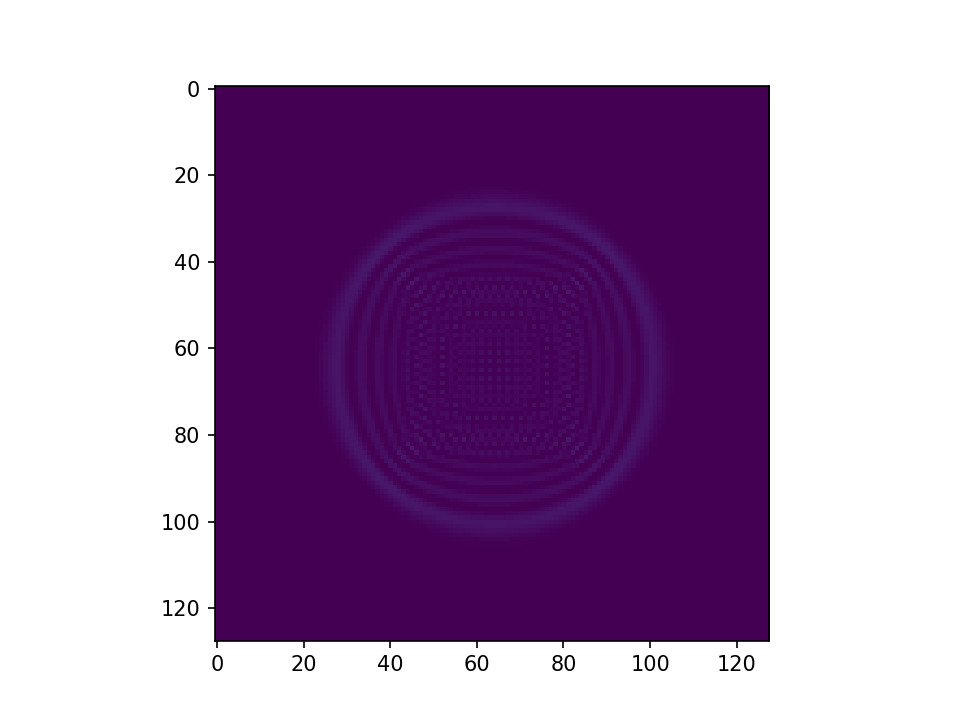

In [21]:
# Start by making an array of zeros to represent no waves in space
wave = np.zeros((128, 128), dtype=float)
wave_prev = np.zeros_like(wave)

# This is a very simple perturbation - we excite 
# the central point with a delta function.  You can move it by 
# changing the indices below
wave[64,64] = 1

# The hard part is making the animation work!
f, ax = plt.subplots(1,1)
image = ax.imshow(wave)
time.sleep(0.1)

for i in range(100):
    wave, wave_prev = iterate_wave(wave, wave_prev, 0.3)
    image.set_data(wave)
    f.canvas.draw()

We have just implemented a very basic wave equation simulator!  Our approach is simple but effective, and we can explore a lot of phenomena with it.  Have a play.  Things you should try are:
* Vary $B$ to explore the effect of changing the speed of the wave.  Is there a maximum that makes sense?
* Move the point source around - what happens when the wave hits an edge? Can you guess why?
* Can you make a line source instead - what does that do to the wave?
* What is the frequency of this wave?

# Radiation at a single frequency
The last question is a bit of a trick: it's a delta function perturbation, so it doesn't have a defined frequency.  If we want a wave with a defined frequency, we need to excite in a slightly more sophisticated way.  We also need to initialise the value of both `wave` and `wave_prev`, because otherwise we'd have a transient at the start of the simulation.

The cell below implements a very simple implementation of a single-frequency source, by adding an oscillating term to particular pixels in the simulation.

<IPython.core.display.Javascript object>


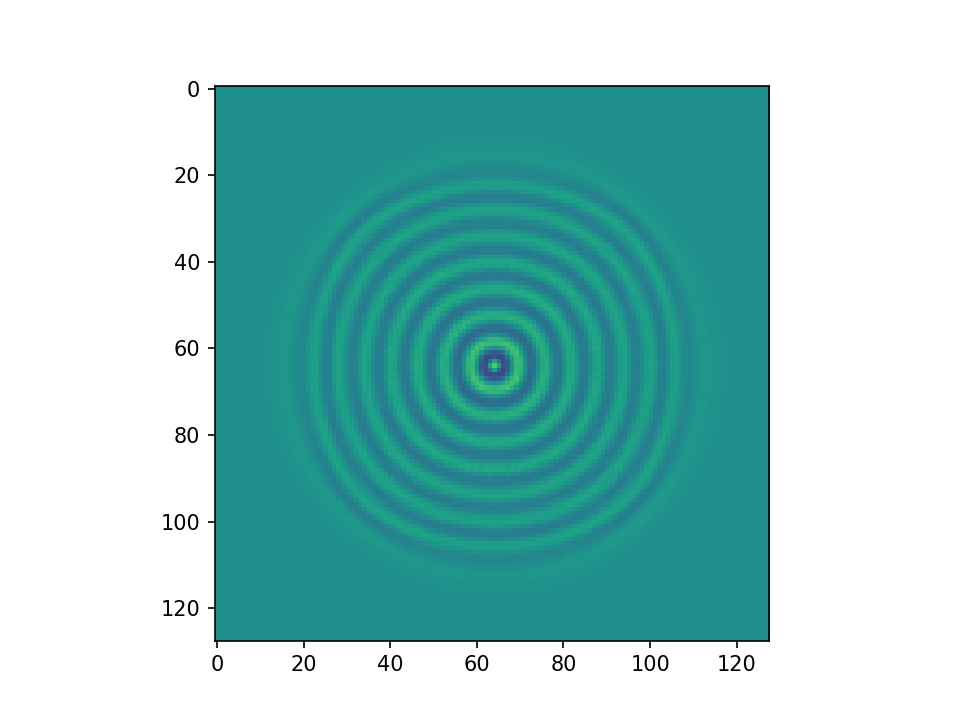

In [31]:
def add_sources(wave, sources, phase):
    """Add sources in to a wavefunction
    """
    return wave + np.real(sources * np.exp(1j * phase))

# Start by making an array of zeros to represent no waves in space
wave = np.zeros((128, 128), dtype=float)
wave_prev = np.zeros_like(wave)
sources = np.zeros_like(wave, dtype=complex)
angular_frequency = 0.5 # wave frequency, in radians-per-step

# This is a very simple perturbation - we excite the central point 
# with a delta function, which we'll now make oscillate in time.
sources[64,64] = 1
# We must initialise the "previous iteration" to avoid a discontinuity
# at the start of the simulation.  We only really need to initialise
# wave_prev, but we do wave as well to get the scale of the graph 
# right.
wave = add_sources(wave, sources, 0)
wave_prev = add_sources(wave_prev, sources, -1*angular_frequency)

# The hard part is making the animation work!
f, ax = plt.subplots(1,1)
image = ax.imshow(wave, vmin=-1, vmax=1)
time.sleep(0.1)

for i in range(100):
    wave = add_sources(wave, sources, i*angular_frequency)
    wave, wave_prev = iterate_wave(wave, wave_prev, 0.5)
    image.set_data(wave)
    f.canvas.draw()

Now that we have a simulation with a source in it, we can do lots of fun things:
* Add two sources, so they interfere like Young's slits.
* Make one of the two sources negative, and see how it changes the interference pattern.
* Make a line source, and see how it changes the radiation pattern.
* Can you make a source pattern that focuses the wave?

<IPython.core.display.Javascript object>


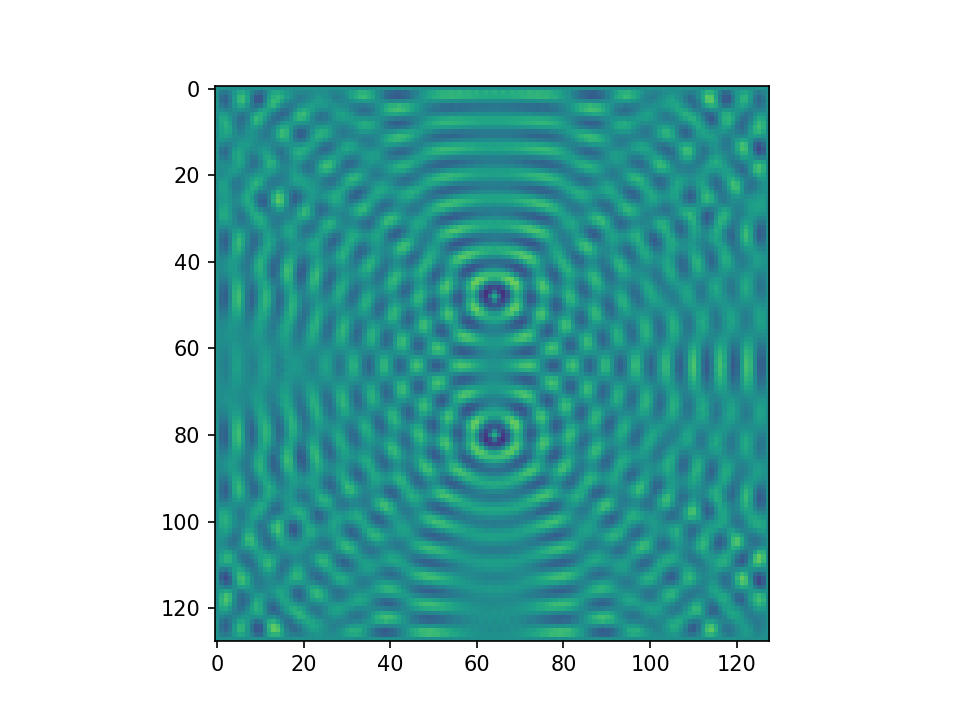

In [42]:
def add_sources(wave, sources, phase):
    """Add sources in to a wavefunction
    """
    return wave + np.real(sources * np.exp(1j * phase))

# Start by making an array of zeros to represent no waves in space
wave = np.zeros((128, 128), dtype=float)
wave_prev = np.zeros_like(wave)
sources = np.zeros_like(wave, dtype=complex)
angular_frequency = 0.5 # wave frequency, in radians-per-step

# This is a very simple perturbation - we excite the central point 
# with a delta function, which we'll now make oscillate in time.

#sources[32:96,64] = 1  # line source
sources[48,64] = 1  # point source 1
sources[80,64] = 1  # point source 2
#sources[64,56] = 1  # point source 3 (for focusing)
#sources[32:96,64] = 0.1*np.exp(-1j*(48**2-(np.arange(64)-32)**2)**0.5)

# We must initialise the "previous iteration" to avoid a discontinuity
# at the start of the simulation.  We only really need to initialise
# wave_prev, but we do wave as well to get the scale of the graph 
# right.
wave = add_sources(wave, sources, 0)
wave_prev = add_sources(wave_prev, sources, -1*angular_frequency)

# The hard part is making the animation work!
f, ax = plt.subplots(1,1)
image = ax.imshow(wave, vmin=-1, vmax=1)
time.sleep(0.1)

for i in range(200):
    wave = add_sources(wave, sources, i*angular_frequency)
    wave, wave_prev = iterate_wave(wave, wave_prev, 0.5)
    image.set_data(wave)
    f.canvas.draw()

In [26]:
wave[64,64]

-1.4342538029085343